<a href="https://colab.research.google.com/github/MarcosVeniciu/Redes_Neurais_Profundas/blob/main/Atividade_1_Classificacao_Jaguatirica_e_Lobo_Guara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

**News:** exercises, examples, import/export files, epoch versus accuracy

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Jaguatiricas vs Lobos Guará binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup
* "[Keras](https://en.wikipedia.org/wiki/Keras) is an open-source software library that provides a Python interface for artificial neural networks."\[[Source Wikipedia](https://en.wikipedia.org/wiki/Keras)\]
* "[Tensorflow](https://en.wikipedia.org/wiki/TensorFlow) is a free and open-source software library for machine learning. It can be used across a range of tasks but has a particular focus on training and inference of deep neural networks." \[[Source Wikipedia](https://en.wikipedia.org/wiki/TensorFlow)\]

![](https://drek4537l1klr.cloudfront.net/chollet2/v-2/Figures/keras_and_tf.png)


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

from numpy import asarray
import pandas as pd

import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

## Load the data: 




In [3]:
!pip3 install user_agent

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for user-agent: filename=user_agent-0.1.10-py3-none-any.whl size=18982 sha256=710cd1045c6fae8bb6ed2eed918e9c276d46369a432a1e7f07533d6616e9cd74
  Stored in directory: /root/.cache/pip/wheels/09/a4/b8/8125d9fb731fb7c785eb41e8eda216297b1a9d4bb28a043397
Successfully built user-agent


In [4]:
import os, time, re, logging, random, shutil
import urllib.request, urllib.error
import matplotlib.pyplot as plt
from urllib.parse import quote
from PIL import Image

from multiprocessing import Pool
from user_agent import generate_user_agent

In [5]:
main_keywords = ['jaguatirica', 'lobo guara']

supplemented_keywords = ['run', 'hidden', 'florest', 'jungle', 'selva' , 'floresta', 'animal', 'filhotes',
     'extinção', 'gato do mato', 'tamanho', 'cerrado', 'cat', 'mato grosso', 'leopard', 'habitat',
        'brasil', 'brazil', 'campo', 'mamifero', 'escondido']

num_classes = len(main_keywords)

Download the images from Google Images

In [ ]:
log_file = 'download.log'
logging.basicConfig(level=logging.DEBUG, filename=log_file, filemode="a+", format="%(asctime)-15s %(levelname)-8s  %(message)s")

def download_page(url):
    try:
        headers = {}
        headers['User-Agent'] = generate_user_agent()
        headers['Referer'] = 'https://www.google.com'
        req = urllib.request.Request(url, headers = headers)
        resp = urllib.request.urlopen(req)
        return str(resp.read())
    except Exception as e:
        print('error while downloading page {0}'.format(url))
        logging.error('error while downloading page {0}'.format(url))
        return None

def parse_page(url):
    """parge the page and get all the links of images, max number is 100 due to limit by google
    
    Args:
        url (str): url of the page
    
    Returns:
        A set containing the urls of images
    """
    page_content = download_page(url)
    if page_content:
        link_list = re.findall('src="(.*?)"', page_content)
        if len(link_list) == 0:
            print('get 0 links from page {0}'.format(url))
            logging.info('get 0 links from page {0}'.format(url))
            return set()
        else:
            return set(link_list)
    else:
        return set()


def download_images(main_keyword, supplemented_keywords, download_dir):
    """download images with one main keyword and multiple supplemented keywords
    
    Args:
        main_keyword (str): main keyword
        supplemented_keywords (list[str]): list of supplemented keywords
    
    Returns:
        None
    """  
    image_links = set()
    print('Process {0} Main keyword: {1}'.format(os.getpid(), main_keyword))

    # create a directory for a main keyword
    img_dir =  download_dir + main_keyword + '/'
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    for j in range(len(supplemented_keywords)):
        print('Process {0} supplemented keyword: {1}'.format(os.getpid(), supplemented_keywords[j]))
        search_query = quote(main_keyword + ' ' + supplemented_keywords[j])
        url = 'https://www.google.com/search?q=' + search_query + '&source=lnms&tbm=isch&safe=active'
        image_links = image_links.union(parse_page(url))
        print('{0} Process {1} get {2} links so far'.format('Google Images', os.getpid(), len(image_links)))
        time.sleep(2)
    print ("Process {0} get totally {1} links".format(os.getpid(), len(image_links)))

    print ("Start downloading...")
    count = 1
    for link in image_links:
        try:
            req = urllib.request.Request(link, headers = {"User-Agent": generate_user_agent()})
            response = urllib.request.urlopen(req)
            data = response.read()
            file_path = img_dir + '{0}.jpg'.format(count)
            with open(file_path,'wb') as wf:
                wf.write(data)
            print('Process {0} fininsh image {1}/{2}.jpg'.format(os.getpid(), main_keyword, count))
            count += 1
        except urllib.error.URLError as e:
            logging.error('URLError while downloading image {0}\nreason:{1}'.format(link, e.reason))
            continue
        except urllib.error.HTTPError as e:
            logging.error('HTTPError while downloading image {0}\nhttp code {1}, reason:{2}'.format(link, e.code, e.reason))
            continue
        except Exception as e:
            logging.error('Unexpeted error while downloading image {0}\nerror type:{1}, args:{2}'.format(link, type(e), e.args))
            continue
    print("Finish downloading, total {0} errors".format(len(image_links) - count))

if __name__ == '__main__':
    
    download_dir = './PetImages/'

    # download with multiple process
    p = Pool() # number of process is the number of cores of your CPU
    for i in range(len(main_keywords)):
        p.apply_async(download_images, args=(main_keywords[i], supplemented_keywords, download_dir))
    p.close()
    p.join()
    print('All fininshed')

Now we have a `PetImages` folder which contain two subfolders, `jaguatirica` and `lobo_guara`. Each
 subfolder contains image files for each category.


In [73]:
!ls PetImages > classes.txt && cat classes.txt

jaguatirica
lobo guara


In [74]:
# Count number of files
for key in main_keywords:
  path, dirs, files = next(os.walk("PetImages/" + key))
  print("directory %s has %d images!" %(key, len(files)))

directory jaguatirica has 3224 images!
directory lobo guara has 3370 images!


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [75]:
num_skipped = 0
for folder_name in main_keywords:
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 37 images


In [76]:
# Count number of files
import os

for key in main_keywords:
  path, dirs, files = next(os.walk("PetImages/" + key))
  print("directory %s has %d images!" %(key, len(files)))

directory jaguatirica has 3213 images!
directory lobo guara has 3344 images!


Remove **two** images for each class and print them.

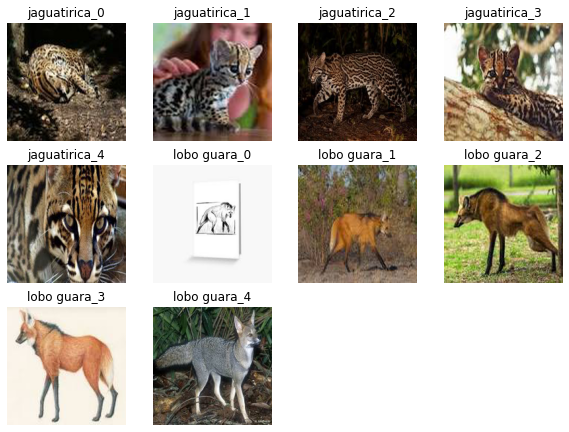

In [11]:
from PIL import Image
import math

list_image = []
for key in main_keywords:
  path, dirs, files = next(os.walk("PetImages/" + key))
  for i in range(5):
    c = str(random.randint(0,len(files)))
    try:
      shutil.move(path+"/"+c+".jpg", "/content/"+key+"_"+str(i)+".jpg")
      list_image.append("/content/"+key+"_"+str(i)+".jpg")
    except:
      i = 0 if i == 0 else i-1

# print the image
image_size = (180, 180)
plt.figure(figsize=(10, 10))
i = 0
size = math.ceil(math.sqrt(len(list_image)))
for img in list_image:
    ax = plt.subplot(size, size, i + 1)
    pic = Image.open(img)
    pic = pic.resize(image_size, Image.ANTIALIAS)
    plt.imshow(pic)
    plt.title(img.split("/")[2].split(".")[0])
    plt.axis("off")
    i += 1

### Data Augmentation

#### Funções

In [27]:
def imagem_to_array(imagem_local):
  img = Image.open(imagem_local) 
  return asarray(img)

In [28]:
def array_to_imagem(imagem_array, novo_nome):
  data = tf.keras.preprocessing.image.array_to_img(imagem_array, data_format=None,scale=False,dtype=None)
  data.save(novo_nome)

In [29]:
# Transformaçoes disponiveis

def rotacao90(image):
  return tf.image.rot90(image, 1)

def rotacao180(image):
  return tf.image.rot90(image, 2)

def rotacao270(image):
  return tf.image.rot90(image, 3)

def saturation(image):
  return tf.image.adjust_saturation(image, 3)

def flip_up_down (image):
  seed = (2, 3)
  return tf.image.stateless_random_flip_up_down(image, seed)

def rotacao90_flip_left_right(image):
  imagem = tf.image.rot90(image, 1)
  return tf.image.flip_left_right(imagem)

def rotacao90_flip_up_down(image):
  seed = (2, 3)
  imagem = tf.image.rot90(image, 1)
  return tf.image.stateless_random_flip_up_down(imagem, seed)


In [30]:
# Transforma e salva as novas imagens

# Transformação 1
def transformacao_1 (imagem, local, nome):
  transformada = rotacao90(imagem)
  novo_nome = "rotacao90_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 2
def transformacao_2 (imagem, local, nome):
  transformada = rotacao180(imagem)
  novo_nome = "rotacao180_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 3
def transformacao_3 (imagem, local, nome):
  transformada = rotacao270(imagem)
  novo_nome = "rotacao270_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 4
def transformacao_4 (imagem, local, nome):
  transformada = rotacao90_flip_up_down(imagem)
  novo_nome = "rotacao90_flip_up_down_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 5
def transformacao_5 (imagem, local, nome):
  transformada = flip_up_down(imagem)
  novo_nome =  "flip_up_down_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 6
def transformacao_6 (imagem, local, nome):
  transformada = rotacao90_flip_left_right(imagem)
  novo_nome = "rotacao90_flip_left_right_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)

# Transformação 7
def transformacao_7 (imagem, local, nome):
  transformada = saturation(imagem)
  novo_nome = "saturation_" + nome
  dir = local + novo_nome
  array_to_imagem(transformada, dir)


In [31]:
def DataAugmentation (local, total):
  lista = os.listdir(local) #lisa com o nome das imagens que estão na pasta

  indices_sorteados = random.sample(range(len(lista)), len(lista)) # sorteia as imagens que seram tranformadas

  contagem = len(lista)# definida uma unica vez

  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_1 (imagem, local, nome) # rotacao 90

    contagem = contagem +1
    indice = indice +1

  
  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_2 (imagem, local, nome) # rotacao 180

    contagem = contagem +1
    indice = indice +1

  
  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_3 (imagem, local, nome) # rotacao 270

    contagem = contagem +1
    indice = indice +1


  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_4 (imagem, local, nome) # rotacao 90 + flip up down

    contagem = contagem +1
    indice = indice +1


  
  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_5 (imagem, local, nome) # flip up down

    contagem = contagem +1
    indice = indice +1


  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_6 (imagem, local, nome) # rotacao 90 + flip left right

    contagem = contagem +1
    indice = indice +1


  indice = 0 # reseta a cada nova transformação
  while ( (contagem < total) and (indice < len(indices_sorteados)) ):
    i = indices_sorteados[indice]
    imagem_local = local +lista[i]
    imagem = imagem_to_array(imagem_local) # converte a imagem para um array
    nome = lista[i] 

    transformacao_7 (imagem, local, nome) # saturation

    contagem = contagem +1
    indice = indice +1

In [32]:
# Contar o numero de imagens nas pastas

def Contar_Imagens():
  !echo Jaguatirica
  print(len(os.listdir("/content/PetImages/jaguatirica")))
  !echo Lobo Guara 
  print(len(os.listdir("/content/PetImages/lobo guara")))

#### Aplicando o aumanto de imagens

In [33]:
# Aplicas varias transformações em todas as imagens presentes nas classes.
total = 3210 #Total de imagens por classe

locais = ["/content/PetImages/jaguatirica/", "/content/PetImages/lobo guara/"]
for local in locais:# Percorre todos as classes
  # Realiza o aumento de dados
  DataAugmentation (local, total) # Realiza o aumento de dados na classe

Contar_Imagens() # Conta o numero de imagens apos o aumento de dados 

Jaguatirica
3210
Lobo Guara
3210


## Generate a `Dataset`


In [82]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 6557 files belonging to 2 classes.
Using 5246 files for training.
Found 6557 files belonging to 2 classes.
Using 1311 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "lobo guará"
 and label 0 is "jaguatirica".


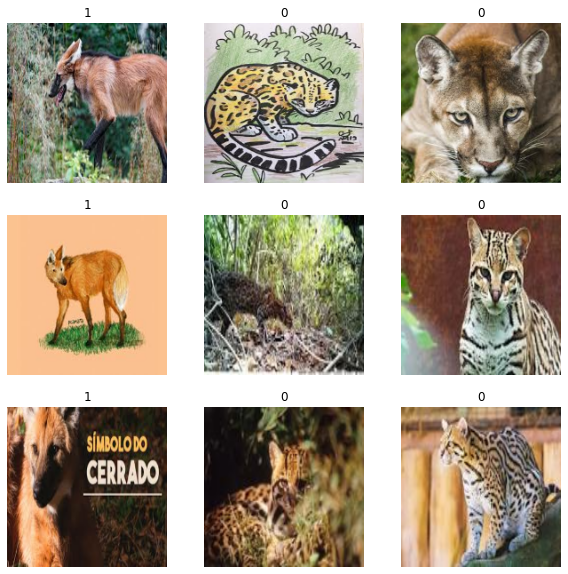

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [83]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


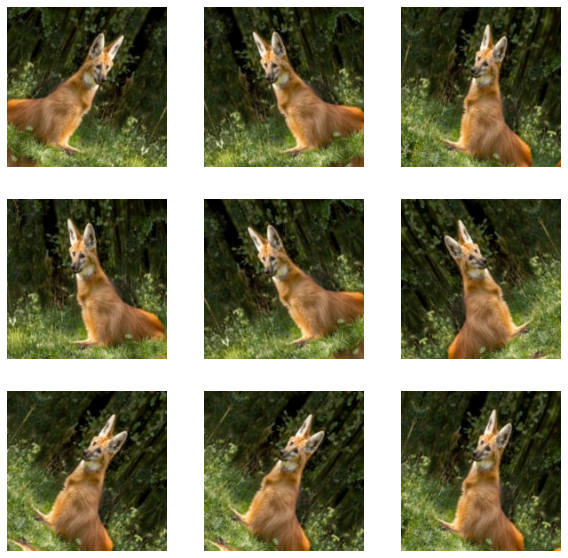

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [84]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


### Xception

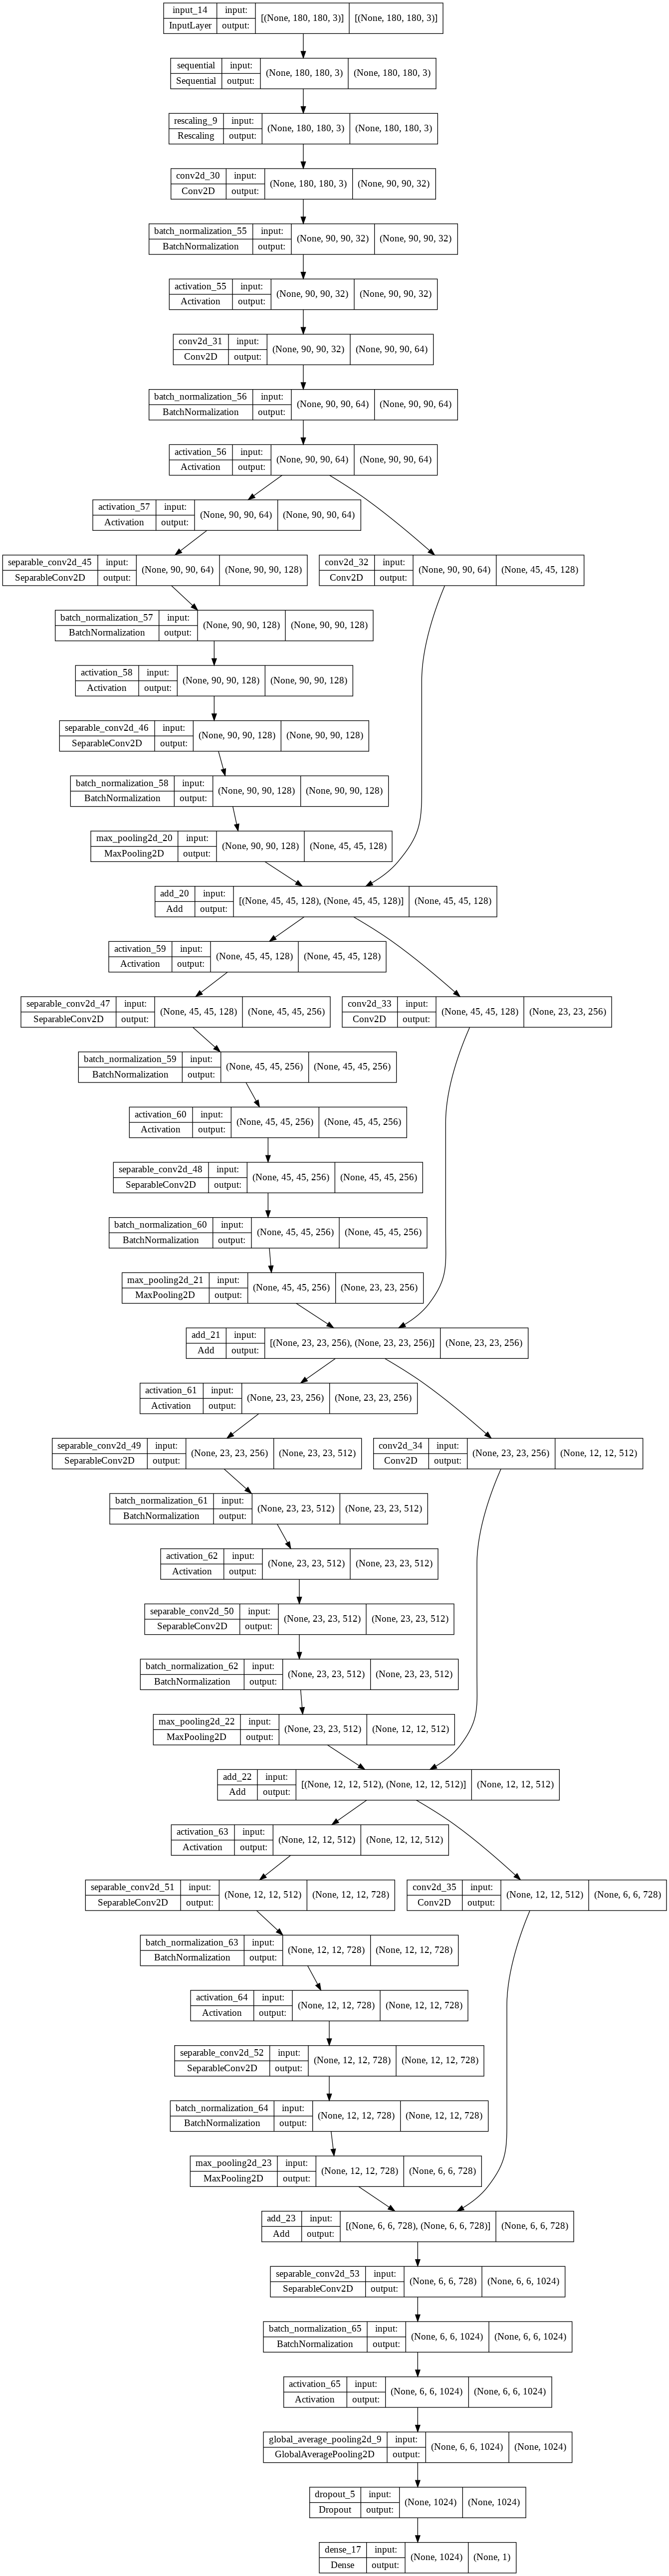

In [77]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 32)   896         ['rescaling[0][0]']          

### MobileNetV2

In [40]:
def MobileNetV2(input_shape, num_classes, dropout):
  base_model = keras.applications.MobileNetV2(
    weights= None,  # Os pesos serão inicializados aleatóriamente.
    input_shape= input_shape,
    alpha=1.0,
    include_top=False, # Não vai incluir a camada de classificação.
  )

  # Freeze the base_model
  base_model.trainable = True # Sendo True vai permitir que os pesos sejam atualizados durante o treinamento

  inputs = keras.Input(shape = input_shape)
  x = data_augmentation(inputs)  # Apply random data augmentation

  scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(x)

  x = base_model(x, training=True)
  x = keras.layers.GlobalAveragePooling2D()(x)

  if num_classes == 2:
    activation = "sigmoid"
    units = 1
  else:
    activation = "softmax"
    units = num_classes

  x = keras.layers.Dropout(dropout, name="dropout_2")(x) # Regularize with dropout
  x = keras.layers.Dense(640, activation='relu')(x)
  x = keras.layers.Dense(320, activation='relu')(x)
  outputs = keras.layers.Dense(units, activation=activation)(x)
  
  return keras.Model(inputs, outputs)  

In [ ]:
modelo = MobileNetV2(input_shape=image_size + (3,), num_classes=num_classes, dropout = 0.5)
modelo.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 mobilenetv2_1.00_180 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0   

## Train the model


In [ ]:
historicos = []

In [85]:
# callbacks
espera = 3 
espera_2 = 5
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                              mode = "min",
                                              patience = espera,
                                              factor=0.2,# 20% da taxa atual, reduz em 80%. nova lr = lr * fator
                                              min_lr=0.0000001, # Reduz ate 1e-7
                                              verbose = 1)
earlystopping =  keras.callbacks.EarlyStopping(monitor ="val_loss", 
                                               mode ="min", 
                                               patience = espera_2, 
                                               restore_best_weights = True)

In [86]:
num_classes = 2
input_shape=image_size + (3,)


model = make_model(input_shape, num_classes)
#model = MobileNetV2(input_shape=input_shape, num_classes=num_classes, dropout = 0.5)

epochs = 50

# choose the loss function correct
loss = "SparseCategoricalCrossentropy" if num_classes >= 3 else "binary_crossentropy"

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    #loss="binary_crossentropy",
    loss=loss,
    metrics=["accuracy"],
)

In [87]:
historico = model.fit(train_ds, epochs=epochs, callbacks=[reduce_lr, earlystopping], validation_data=val_ds,)
historicos.append(historico)

Epoch 1/50
164/164 [==============================] - 48s 270ms/step - loss: 0.5038 - accuracy: 0.7720 - val_loss: 0.6874 - val_accuracy: 0.5233 - lr: 0.0010
Epoch 2/50
164/164 [==============================] - 41s 249ms/step - loss: 0.3549 - accuracy: 0.8546 - val_loss: 0.6995 - val_accuracy: 0.5133 - lr: 0.0010
Epoch 3/50
164/164 [==============================] - 42s 254ms/step - loss: 0.3100 - accuracy: 0.8719 - val_loss: 0.5681 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 4/50
164/164 [==============================] - 43s 260ms/step - loss: 0.2860 - accuracy: 0.8858 - val_loss: 0.3291 - val_accuracy: 0.8856 - lr: 0.0010
Epoch 5/50
164/164 [==============================] - 43s 259ms/step - loss: 0.2733 - accuracy: 0.8902 - val_loss: 0.7205 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 6/50
164/164 [==============================] - 43s 260ms/step - loss: 0.2598 - accuracy: 0.8969 - val_loss: 0.3989 - val_accuracy: 0.8589 - lr: 0.0010
Epoch 7/50
164/164 [==============================] 

In [89]:
nome_modelo = "Atividade_1_Xception_com_augmentation"

In [90]:
# salva o modelo treinado no drive
local_modelo = "/content/" + nome_modelo + ".h5"
model.save(local_modelo)

In [ ]:
def diferenca(historico):
  accuracy = historico.history['accuracy'] 
  val_accuracy = historico.history['val_accuracy']
  vetor_diferenca = []

  for i in range(len(accuracy)):
    diferenca = abs(accuracy[i] - val_accuracy[i])
    vetor_diferenca.append(diferenca)

  return vetor_diferenca


for i in range(len(historicos)):

  historico = historicos[i]

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,3,1)
  plt.title(nome_modelo + ' V' + str(i) + ': Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.plot(historico.history['loss'], label='Train Loss', color = 'blue')
  plt.plot(historico.history['val_loss'], label='Val Loss', color = 'red')
  plt.legend()

  # Grafico 2: Acurácia
  plt.subplot(1,3,2)
  plt.title(nome_modelo + ' V' + str(i) + ': Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.grid()
  plt.plot(historico.history['accuracy'],  label='Train Accuracy' , color = 'blue')
  plt.plot(historico.history['val_accuracy'],label = 'Val Accuracy', color = 'red')
  plt.legend()

  # Grafico 3: Diferença de Acurácia
  vetor_diferenca = diferenca(historico)

  plt.subplot(1,3,3)
  plt.title("Variação da Acurácia: " + nome_modelo + " V"+ str(i))
  plt.xlabel("Epocas")
  plt.ylabel("Pontos Percentuais")
  plt.grid()
  plt.plot(vetor_diferenca, color = 'red', label = 'variação da acuracia')
  plt.legend()

  plt.show()

MobileNetV2 - com DataAugmentation \
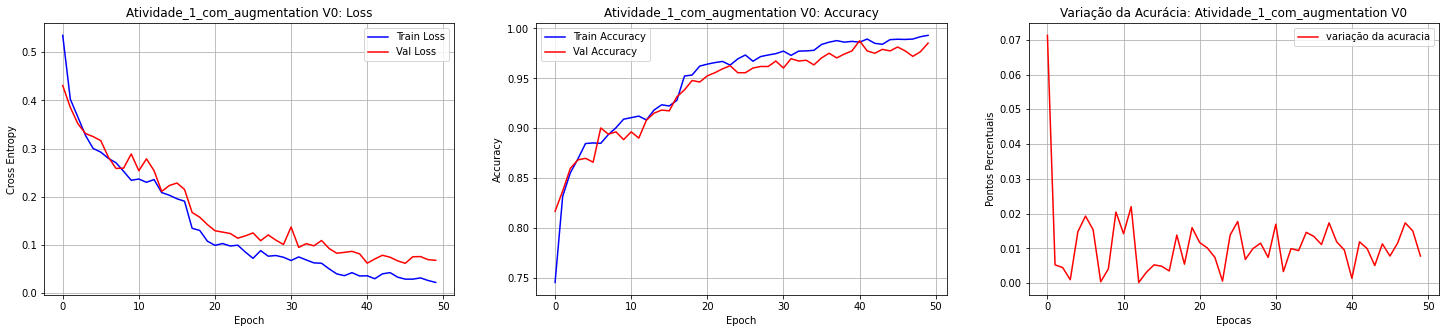 \
--------------------------------------------------------------------------------------------------------------- \
Xception com Data Augmentation \
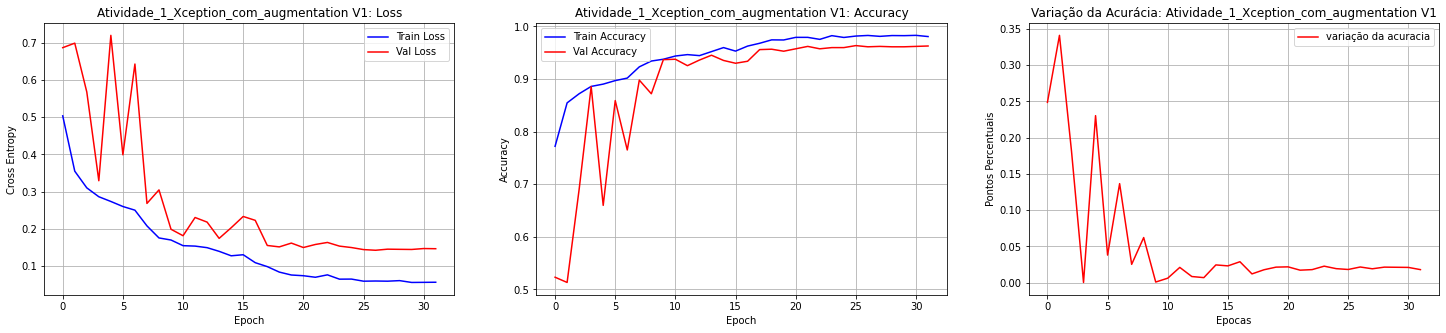


In [ ]:
model.evaluate(val_ds)

MobiliNet sem data Augmentation \
8/8 [==============================] - 0s 38ms/step - loss: 0.2909 - accuracy: 0.8730 \
[0.2909056842327118, 0.8729507923126221] \
-------------------------------------------------------------------- \
mobileNetV2 com Data Augmentation \
41/41 [==============================] - 2s 37ms/step - loss: 0.0583 - accuracy: 0.9844 \
[0.0582796186208725, 0.9844236969947815] \
------------------------------------------------------------------- \
Xception com Data Augmentation \
41/41 [==============================] - 2s 48ms/step - loss: 0.1420 - accuracy: 0.9611 \
[0.1419616937637329, 0.9610983729362488]

# Comparando Modelos


In [48]:
# Faz o download do modelo treinado pelo professor
!wget https://github.com/arduinoufv/keras/raw/main/lab_models/model_lab1.h5 

--2022-09-12 19:44:06--  https://github.com/arduinoufv/keras/raw/main/lab_models/model_lab1.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/arduinoufv/keras/main/lab_models/model_lab1.h5 [following]
--2022-09-12 19:44:06--  https://raw.githubusercontent.com/arduinoufv/keras/main/lab_models/model_lab1.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11248928 (11M) [application/octet-stream]
Saving to: ‘model_lab1.h5’

model_lab1.h5       100%[===================>]  10.73M  --.-KB/s    in 0.03s   

2022-09-12 19:44:09 (418 MB/s) - ‘model_lab1.h5’ saved [11248928/11248928]



In [62]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.load_weights("/content/model_lab1.h5")

In [70]:
# Carrega o melhor modelo
local_modelo = "/content/Atividade_1_com_augmentation.h5"
model = load_model(local_modelo)

# Realizando as predições

In [94]:
# Cria um dataframe vazio para as previsões do modelo
df = pd.DataFrame([], columns=['classe_real', 'predicao'])

# Realiza a predição
y_true = []
y_pred = []
for image_batch, labels_batch in val_ds:
  y_pred_itera = model.predict(image_batch)
  y_true_intera = labels_batch.numpy()
  for i in range(len(y_true_intera)):
    y_true.append(y_true_intera[i])  
    y_pred.append(y_pred_itera[i][0])


for i in range(len(y_pred)):
  df = df.append({'classe_real' : y_true[i], 'predicao': y_pred[i]} ,ignore_index=True)   

#Criando o CSV: nomeclatura, atividade_X e professor
nome_modelo = "Atividade 1 - Xception com Data Augmentation"
if (nome_modelo != ""):
  Nome_arquivo = "classificacao_" + nome_modelo + ".csv"
  df.to_csv(Nome_arquivo, index = False)
else: print("Informe o nome do modelo!")

## Analise das predições

In [96]:
lista_de_modelos = ["Atividade 1 - com Data Augmentation", "Atividade 1 - sem Data Augmentation", "Professor", "Atividade 1 - Xception com Data Augmentation"]

y_true = []
y_pred = []

for modelo_nome in lista_de_modelos:
  local_modelo = "/content/classificacao_" + modelo_nome + ".csv"
  df = pd.read_csv(local_modelo)
  
  y_true_local = []
  for classe_real in df["classe_real"]:
    y_true_local.append(int(classe_real)) 
  
  y_pred_local= []
  for predicao in df["predicao"]:
    y_pred_local.append(predicao)
  
  y_true.append(y_true_local)
  y_pred.append(y_pred_local)  

Acurácia e F1-score

In [97]:
precisao = 0.50
indice = 0

for modelo in lista_de_modelos:
  y_pred_copia = []
  for predicao in y_pred[indice]:
    if predicao > precisao: # classe 1
      y_pred_copia.append(1)
    else:
      y_pred_copia.append(0)
      
  print("   Modelo: " + str(modelo))
  print(classification_report(y_true[indice], y_pred_copia))
  print("------------------------------------------------------")
  indice = indice +1

   Modelo: Atividade 1 - com Data Augmentation
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       638
           1       0.98      0.98      0.98       646

    accuracy                           0.98      1284
   macro avg       0.98      0.98      0.98      1284
weighted avg       0.98      0.98      0.98      1284

------------------------------------------------------
   Modelo: Atividade 1 - sem Data Augmentation
              precision    recall  f1-score   support

           0       0.93      0.75      0.83       638
           1       0.79      0.94      0.86       646

    accuracy                           0.85      1284
   macro avg       0.86      0.85      0.84      1284
weighted avg       0.86      0.85      0.84      1284

------------------------------------------------------
   Modelo: Professor
              precision    recall  f1-score   support

           0       0.59      0.16      0.26       638
           1

Matriz de confusão

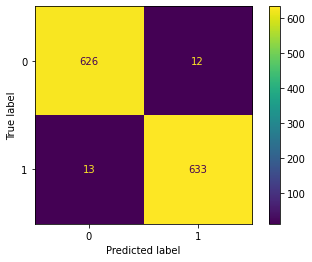

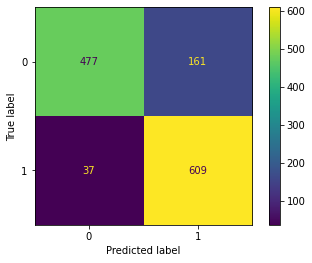

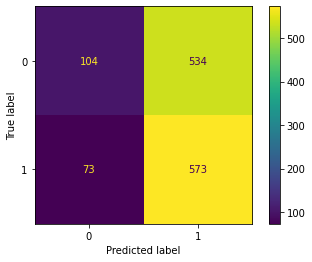

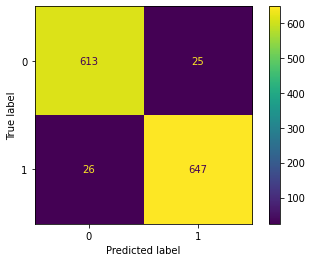

In [98]:
precisao = 0.5000

indice = 0
for modelo in lista_de_modelos:
  y_pred_copia = []
  for predicao in y_pred[indice]:
    if predicao > precisao:
      y_pred_copia.append(1)
    else: 
      y_pred_copia.append(0)
  cm = confusion_matrix(y_true[indice], y_pred_copia)
  cm_display = ConfusionMatrixDisplay(cm).plot()
  indice = indice +1

Curva ROC

In [99]:
fpr = dict()
tpr = dict()
roc_auc = dict()

indice = 0
for modelo in lista_de_modelos:
  fpr[indice], tpr[indice], _ = roc_curve(y_true[indice], y_pred[indice])
  roc_auc[indice]= auc(fpr[indice], tpr[indice])
  indice = indice +1

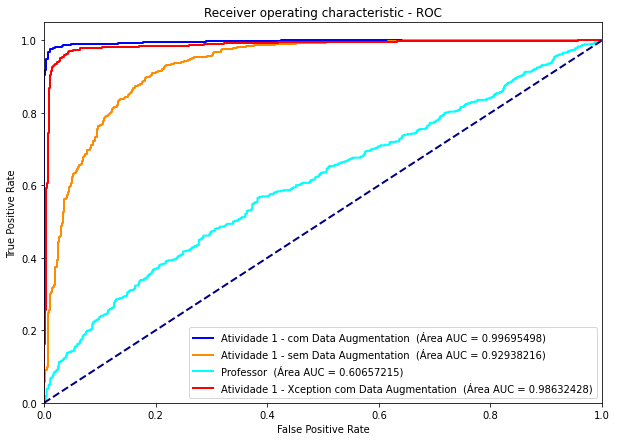

In [100]:
n_modelos = len(lista_de_modelos)

plt.figure(figsize  = (10, 7))
lw = 2
colors = cycle(["Blue", "darkorange", "aqua", "red"])
for i, color in zip(range(n_modelos), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="{0}  (Área AUC = {1:0.8f})".format(lista_de_modelos[i], roc_auc[i]),
    )
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic - ROC")
plt.legend(loc="lower right")
plt.show()

# Explicações do professor

We get to ~84% validation accuracy after training for 50 epochs on the full dataset.


## Time to training....

* $6.84s \times 50$ epoches $=342s=5 min 42s.

* Assuming a GPU computes 1 TeraFlops/s;

* Parameters = 2,773,913

* $342$ Tera Flops

* 342 Tera / 2,773,913 = $123.2 M$ FLops per parameter

* 180x180 pixels * 3 colors * 1,430 images * 80 % = 111,19 M input data points.


## Read pre-trained model

[Download the pre-trained model](https://github.com/arduinoufv/keras/blob/main/lab_models/model_lab1.h5)

Upload it in your drive.

## Waiting to upload and check the size 

```-rw-r--r-- 1 root root 11248928 Mar 10 20:28 model_lab1.h5```


In [ ]:
!ls -la *.h5

## Load the weights from a pre-trained model

In [ ]:
model.load_weights("/content/save_at_49.h5")

## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
# read in order of classes
classes = []
arq = open("classes.txt", "r")
for l in arq.readlines():
  classes.append(l[:-1])

# print the list of images and give probability the type of class
for pic in list_image:
  img = keras.preprocessing.image.load_img(
      pic, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0]

  # Get results 
  print("Image:",pic.split("/")[2])
  for i in range(len(classes)):
    if len(classes) > 2:
      print("%s %5.2f %%" %(classes[i], score[i] * 100))
    else:
      print("%s %5.2f %%" %(classes[i], score * 100))
      print("%s %5.2f %%" %(classes[i+1], (1-score) * 100))
      break
  print()

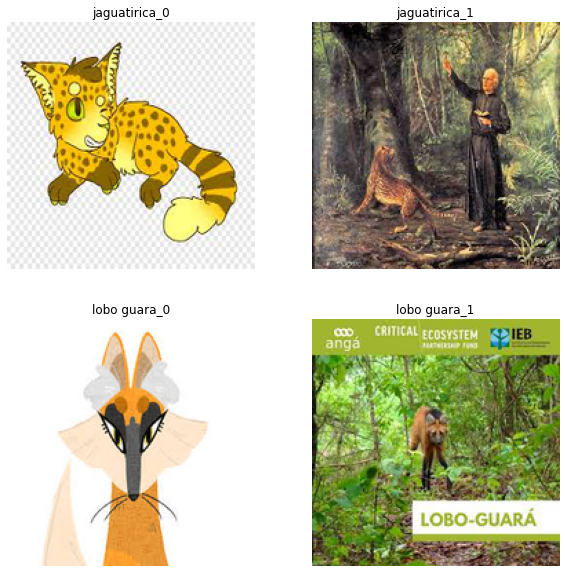

In [ ]:
# print the image
image_size = (180, 180)
plt.figure(figsize=(10, 10))
i = 0
size = math.ceil(math.sqrt(len(list_image)))
for img in list_image:
    ax = plt.subplot(size, size, i + 1)
    pic = Image.open(img)
    pic = pic.resize(image_size, Image.ANTIALIAS)
    plt.imshow(pic)
    plt.title(img.split("/")[2].split(".")[0])
    plt.axis("off")
    i += 1

# How to save a model in Colab

Keras models:
* Saving the architecture / configuration only, typically as a JSON file.
* Saving the weights values only. This is generally used when training the model.

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


# How to import/export files

[Tips on portuguese language](https://colab.research.google.com/drive/1iSN88RoTa7fnCDA9zz_RBE-H1mLB0dCh?usp=sharing)


# How to download to your desktop


In [ ]:
from google.colab import files
# uncomment the next line and replace my_file with your file + the path
#files.download('/content/myfile')
#
# example
files.download('/content/model.json')
files.download('/content/model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# How to save in your Google Drive


Execute the following cell, get your code.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Now you can see your drive folder in:

**/content/gdrive/My Drive/**



# Upload photos from your local Computer 

In [ ]:
from google.colab import files
files.upload()

Saving cat.jpg to cat.jpg


{'cat.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\x07\x07\x07\x07\x08\x07\x08\t\t\x08\x0c\x0c\x0b\x0c\x0c\x11\x10\x0e\x0e\x10\x11\x1a\x12\x14\x12\x14\x12\x1a\'\x18\x1d\x18\x18\x1d\x18\'#*" "*#>1++1>H<9<HWNNWmhm\x8f\x8f\xc0\x01\x07\x07\x07\x07\x08\x07\x08\t\t\x08\x0c\x0c\x0b\x0c\x0c\x11\x10\x0e\x0e\x10\x11\x1a\x12\x14\x12\x14\x12\x1a\'\x18\x1d\x18\x18\x1d\x18\'#*" "*#>1++1>H<9<HWNNWmhm\x8f\x8f\xc0\xff\xc2\x00\x11\x08\x01\x89\x02\xdf\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x01\x05\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x01\x02\x03\x05\x06\x07\x08\xff\xda\x00\x08\x01\x01\x00\x00\x00\x00\xea\'))$\x99\x92wL\xc9$\x92gd\xe9:I:I:N\x93\xbaI$\xee\x9e5QMW\x98i7NS\x9eV>\x96\xa6o9\x85\xcf\x00\x00\x0b\xae\xec\xcf\xbd\xc16\xc7\x93\xbaI3:t\xcc\xc9$\x92I$\x9d$\x93\xa4\x9d\xd2t\xe9\xd2I\xd2t\xd5QEW\x98q6\xceS\x0b\x90\xd0\xe9\xe7\x95\xce\xe4\n \x18y\x8d\xb3\xa7\xad\xd1X}\x92\x93\xbaI\x93\'t\xcc\xc9&I$\x92t\x92t

## Prediction

Image: cat.jpg
jaguatirica 95.29 %
lobo guara  4.71 %


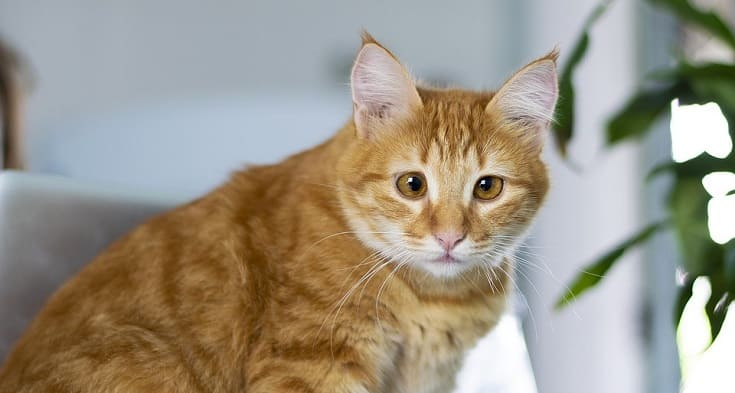

In [ ]:
filename = "cat.jpg"
img = keras.preprocessing.image.load_img(
    filename, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]

# Get results 
print("Image:", filename)
for i in range(len(main_keywords)):
  if len(main_keywords) > 2:
    print("%s %5.2f %%" %(main_keywords[i], score[i] * 100))
  else:
    print("%s %5.2f %%" %(main_keywords[i], score * 100))
    print("%s %5.2f %%" %(main_keywords[i+1], (1-score) * 100))
    break

from IPython.display import Image, display
display(Image(filename))